In [11]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import dxpy

COLORS = plt.rcParams['axes.prop_cycle'].by_key()['color']

df_dict = {}

OBESITY_PHENOS = [
  'body_mass_index_bmi',
  'whr_adj_bmi',
  'bmi_impedance',
  'body_fat_percentage',
  'visceral_adipose_tissue_volume_vat',
  'abdominal_fat_ratio',
  'gynoid_tissue_fatp',
  'android_tissue_fatp',
  'total_tissue_fatp',
  'tissuefatp_androidgynoidratio'
]

genebass_file_dict = {
    'whr_adj_bmi': 'WHRadjBMI_custom-both_sexes--custom',
    'body_fat_percentage': '23099-both_sexes--irnt',
    'bmi_impedance': '23104-both_sexes--irnt',
    'body_mass_index_bmi': '21001-both_sexes--irnt',
    'visceral_adipose_tissue_volume_vat': '22407-both_sexes--irnt',
    'alanine_aminotransferase': '30620-both_sexes--irnt',
    
}

DNAX_DATA_DIR='/mnt/project/saige_pipeline/data'
LOCAL_DATA_DIR='/Users/nbaya/gms/lindgren/ukb_wes/ukb_wes_450k_gwas/data'

DATA_DIR=LOCAL_DATA_DIR

### S0. Define functions

In [13]:
def old1_get_saige_path(pheno, chrom, sex='both_sexes', assoc='variant'):
    if assoc=='variant':
        return f'{DATA_DIR}/old-02_saige_variant_test/saige_variant_test.{pheno}{f"-{sex}" if sex != "both_sexes" else ""}.chr{chrom}.tsv'

def old2_get_saige_path(pheno, chrom, sex='both_sexes', assoc='gene_assoc'):
    """
    Run with variant and gene-based assocation simultaneously. Results are weird.
    """
    return f'{DATA_DIR}/02_saige_all_test/{sex}/saige_all_test.{pheno}{f"-{sex}" if sex != "both_sexes" else ""}.chr{chrom}.{assoc}_assoc.tsv'


def get_saige_results_path(pheno, chrom, sex='both_sexes', assoc='variant'):
    return f'{DATA_DIR}/02_saige_{assoc}_test/saige_{assoc}_test.{pheno}{f"-{sex}" if sex != "both_sexes" else ""}.chr{chrom}.tsv'
    
def read_saige_gwas(pheno, sex='both_sexes'):

    df_list = []

    for chrom in list(range(1,23))+['X']:
        try:
            path = get_saige_results_path(pheno=pheno, chrom=chrom, sex=sex, assoc='variant')
            df_tmp = pd.read_csv(path, sep='\t')
            df_list.append(df_tmp)
        except:
            print(f'No file for {pheno} sex={sex} chr{chrom}')
    df =  pd.concat(df_list, axis=0)
    df = df.rename(columns={'POS':'position'})
    df['CHISQ'] = (df.BETA/df.SE)**2
    df['nlog10pval'] = -np.log10(df['p.value'])
    df['maf'] = pd.concat([df['AF_Allele2'], 1-df['AF_Allele2']], axis=1).min(axis=1)
#     print(f'Removing {(df.CHR!="UR").sum()} lines with "UR"')
#     df = df[df.CHR!='UR']
    df['position'] = df['position'].astype(int)
    
    return df

def read_genebass_results(pheno, assoc='variant'):
    genebass_suffix = genebass_file_dict[pheno]
    if assoc=='gene':
        gb = pd.read_csv(f'{DATA_DIR}/genebass/gene-burden-results-exomes_pLoF_continuous-{genebass_suffix}.csv')
    elif assoc=='variant':
        gb = pd.read_csv(f'{DATA_DIR}/genebass/single-variant-associations-exomes_continuous-{genebass_suffix}.csv')
        gb['CHR'] = gb['Variant ID'].str.split('-', expand=True)[0]
        gb['position'] = gb['Variant ID'].str.split('-', expand=True)[1]
        gb['Allele1'] = gb['Variant ID'].str.split('-', expand=True)[2]
        gb['Allele2'] = gb['Variant ID'].str.split('-', expand=True)[3]
        
    return gb

def plot_manhattan(df, min_maf=1e-6, log_yscale=False, title=''):
    
    start_bp = 0
    mid = []
    chrom_list = []
    plt.figure(figsize=(12, 8))

    for i, chrom in enumerate(range(1, 24)):
        max_pos=0
        
        if chrom==23: chrom='X'
#         try:
        gwas = df[df.CHR.astype(str)==str(chrom)]

#         print(f'Variants with defined p-values chr{chrom}: {gwas.nlog10pval.notna().sum()}')
        try:
            plt.plot(gwas['position']+start_bp,
                 gwas['nlog10pval'], '.', c=COLORS[i % 2])
            max_pos = max(max_pos, max(gwas['position']))
        except:
            max_pos = 0
#             print(f'Failed chr{chrom}')
        mid.append(start_bp+(max_pos)/2)
        start_bp += max_pos
        start_bp += 5e7
        chrom_list.append(chrom)

    left, right = plt.xlim()
    plt.plot([left, right], [-np.log10(5e-7)]*2, 'k--')
    plt.plot([left, right], [-np.log10(0.05/df['p.value'].notna().sum())]*2, 'k--', alpha=0.2)
    plt.xticks(mid, chrom_list)
    plt.title(title)
    plt.xlabel('Chromosome')
    plt.ylabel('-log10(p)')
    plt.xlim([left, right])
    _, ymax = plt.ylim()
    if log_yscale:
        plt.yscale('symlog', linthresh=5)
        plt.ylim([0, ymax**1.05])


def plot_miami(df1, df2, min_maf=1e-6, log_yscale=False, title=''):
    
    start_bp = 0
    mid = []
    chrom_list = []
    plt.figure(figsize=(12, 8))
    for chrom_i, chrom in enumerate(range(1, 24)):
        if chrom==23: chrom='X'
            
        max_pos=0
        for i, df in enumerate([df1, df2]):
            try:
                gwas = df[df.CHR==chrom]

    #             print(f'GWAS {i+1}: Variants with defined p-values chr{chrom}: {gwas.nlog10pval.notna().sum()}')

                plt.plot(
                    gwas['position']+start_bp,
                     ((-1)**i)*gwas['nlog10pval'],  # flip second GWAS to be below
                    '.', c=COLORS[chrom_i % 2]
                )
                max_pos = max(max_pos, max(gwas['position']))
            except:
                print(f'Failed: GWAS {i+1} chr{chrom}')
        mid.append(start_bp+(max_pos)/2)
        start_bp += max_pos
        start_bp += 5e7
        chrom_list.append(chrom)

    left, right = plt.xlim()
    for i in range(2):
        plt.plot([left, right], [-np.log10(5e-7)*(-1)**i]*2, 'k--')
        plt.plot([left, right], [-np.log10(0.05/df['p.value'].notna().sum())*(-1)**i]*2, 'k--', alpha=0.2)
    plt.xticks(mid, chrom_list)
    plt.title(title)
    plt.xlabel('Chromosome')
    plt.ylabel('-log10(p)')
    plt.xlim([left, right])
    _, ymax = plt.ylim()
    if log_yscale:
        plt.yscale('symlog', linthresh=5)
        plt.ylim([0, ymax**1.05])
        
        
def plot_qq(df, nlog10pval_field = 'nlog10pval', maf_bins=None, logscale=False, figsize=(9*1.2,6*1.2), dpi=100, title=''):
    r'''Makes QQ plot for fields in `fields`.

    maf_bins should be a list of tuples, indicating min and max MAF per bin.
    Plots y-axis/x-axis in log scale if `logscale`=True.
    '''
    def get_expected(n):
        """Get expected -log10(p) for `n` observations
        """
        exp = -np.log10(np.linspace(start=1,stop=1/n,num=n)) # to account for weird kink at lower end in log-log scale: -np.log10(np.linspace(start=1-1/df_tmp.shape[0],stop=1/df_tmp.shape[0],num=df_tmp.shape[0]))

        return exp

    # Make 95% confidence interval
    def get_CI_intervals(n, CI=0.95):
        k = np.arange(1,n+1)
        a = k
        b = n+1-k
        intervals=stats.beta.interval(CI, a, b) # get 95% CI with parameters a and b
        return intervals

    def get_lambda_gc(chisq_vec):
        return np.median(chisq_vec)/stats.chi2.ppf(q=0.5, df=1)

    df = df[df[nlog10pval_field].notna()].copy()

    n = df.shape[0]
    exp = get_expected(n)
    intervals = get_CI_intervals(n)

    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    ax.plot(exp,exp,'k--')
    plt.fill_between(
        x=exp[::-1], # need to reverse order of array exp to match intervals
        y1=-np.log10(intervals[0]),
        y2=-np.log10(intervals[1]),
        color='k',
        alpha=0.1,
        label='Expected'
    )

    lambda_gc_dict = {}

    if maf_bins is None:
        exp = get_expected(n=n)
        rank = np.sort(df[nlog10pval_field])
        ax.scatter(exp, rank, label='Observed')
    else:
        for i, (maf_min, maf_max) in enumerate(maf_bins):
            df_tmp = df[(df.maf>maf_min)&(df.maf<=maf_max)]

            n_tmp = df_tmp[nlog10pval_field].notna().sum()
            exp_tmp = get_expected(n_tmp)
            rank_tmp = np.sort(df_tmp[nlog10pval_field])

            lambda_gc_tmp = get_lambda_gc(chisq_vec=df_tmp['CHISQ'])
            lambda_gc_dict[f'({maf_min}, {maf_max}]'] = lambda_gc_tmp

            ax.scatter(
                exp_tmp,
                rank_tmp,
                color=plt.cm.viridis(i/(len(maf_bins)-0.5)),
                label=f'MAF:({maf_min}, {maf_max}]'+r', $\lambda_{GC}=$'+f'{lambda_gc_tmp:.2e}'
            )

    if logscale:
        plt.yscale('log')
        plt.xscale('log')

#    plt.ylim([min(-np.log10(intervals[0])),max(-np.log10(intervals[1]))])
    plt.xlabel(r'Expected -$\log_{10}(p)$')
    plt.ylabel(r'Observed -$\log_{10}(p)$')
    plt.legend(loc='upper left')

    lambda_gc_dict['all'] = get_lambda_gc(chisq_vec=df['CHISQ'])
    plt.title(title+r'$\lambda_{GC}='+f'{lambda_gc_dict["all"]:.2e}$')

    return df, lambda_gc_dict

def compare_to_genebass(df_dict, pheno, assoc='variant'):

    gwas_id_genebass = pheno+'-genebass'

    if gwas_id_genebass not in df_dict:
        df_dict[gwas_id_genebass] = read_genebass_results(pheno=pheno, assoc='variant')
    if pheno not in df_dict:
        df_dict[pheno] = read_saige_gwas(pheno)

    df = df_dict[pheno]
    df_genebass = df_dict[gwas_id_genebass]      
                        
    def uniq_varid(row):
        alleles = '-'.join(sorted([row.Allele1, row.Allele2]))
        return f'{row.CHR}-{row.position}-{alleles}'
    
    df['varid'] = df.apply(uniq_varid, axis=1)
    df_genebass['varid'] = df_genebass.apply(uniq_varid, axis=1)
    merged = df.merge(df_genebass, on='varid')

    plt.figure(dpi=300)
    plt.scatter(
        -np.log10(merged['P-Value']), 
        merged.nlog10pval, alpha=0.5)
    ymin, ymax = plt.ylim()
    xmin, xmax = plt.xlim()
    plt.plot(*[[xmin, xmax]]*2, 'k--')
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    plt.title(pheno)
    plt.xlabel('Genebass -log10(pval)')
    plt.ylabel('Lindgren -log10(pval)')
    
    return merged, df, df_genebass

In [4]:
OBESITY_PHENOS

['body_mass_index_bmi',
 'whr_adj_bmi',
 'bmi_impedance',
 'body_fat_percentage',
 'visceral_adipose_tissue_volume_vat',
 'abdominal_fat_ratio',
 'gynoid_tissue_fatp',
 'android_tissue_fatp',
 'total_tissue_fatp',
 'tissuefatp_androidgynoidratio']

Text(0.5, 1.0, 'body_mass_index_bmi ($\\lambda_{GC}=1.07e+00$)')

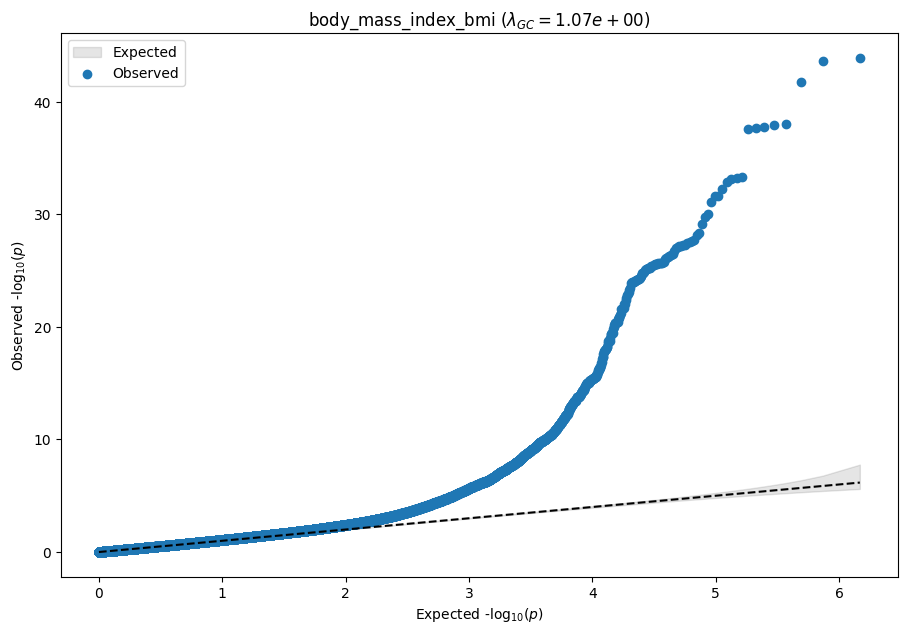

In [12]:
pheno='body_mass_index_bmi'

df_dict[pheno] = read_saige_gwas(pheno)
df = df_dict[pheno]
df, lambda_gc_dict = plot_qq(df=df)
plt.title(f'{pheno} '+r'($\lambda_{GC}='+f'{lambda_gc_dict["all"]:.2e}$)')

Removing 1476414 lines with "UR"


Text(0.5, 1.0, 'body_mass_index_bmi ($\\lambda_{GC}=1.07e+00$)')

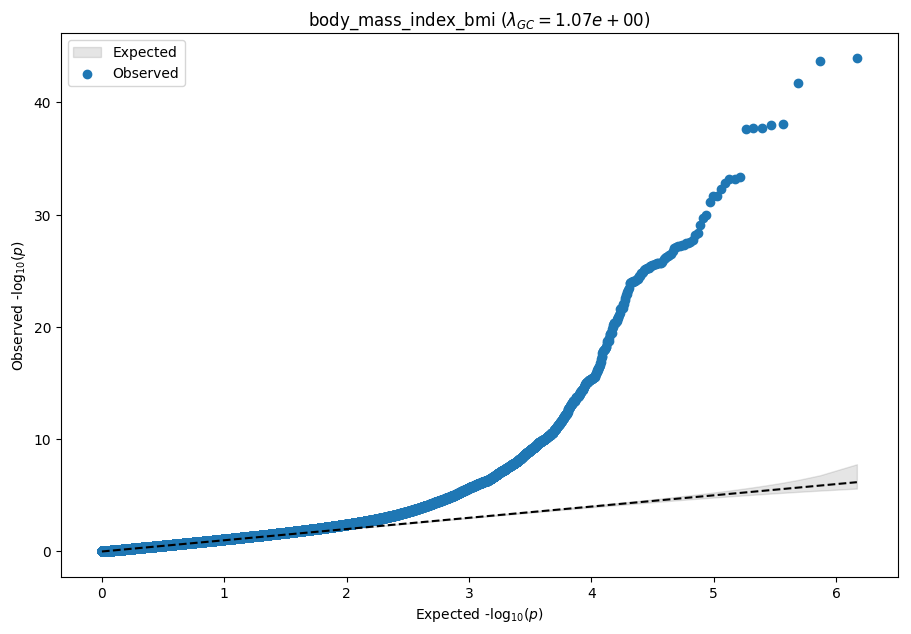

In [7]:
pheno='body_mass_index_bmi'

df_dict[pheno] = read_saige_gwas(pheno)
df = df_dict[pheno]
df, lambda_gc_dict = plot_qq(df=df)
plt.title(f'{pheno} '+r'($\lambda_{GC}='+f'{lambda_gc_dict["all"]:.2e}$)')

Text(0.5, 1.0, 'body_mass_index_bmi ($\\lambda_{GC}=1.07e+00$)')

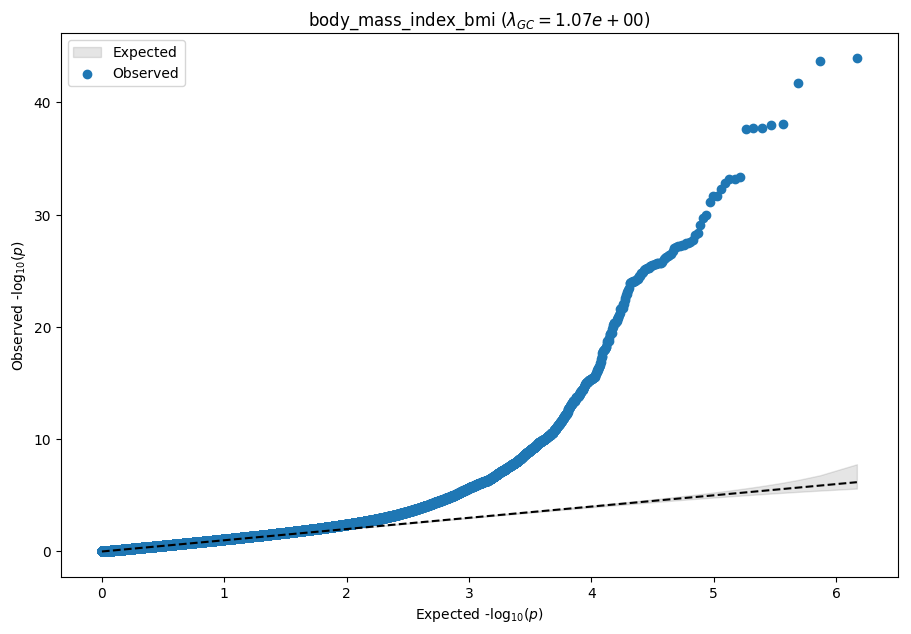

In [17]:
pheno='body_mass_index_bmi'

df_dict[pheno] = read_saige_gwas(pheno)
df = df_dict[pheno]
df, lambda_gc_dict = plot_qq(df=df)
plt.title(f'{pheno} '+r'($\lambda_{GC}='+f'{lambda_gc_dict["all"]:.2e}$)')

/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/opt/conda/lib/python3.6/site-packages/matplotlib/axes/_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/opt/conda/lib/python3.6/site-packages/matplotlib/axes/_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


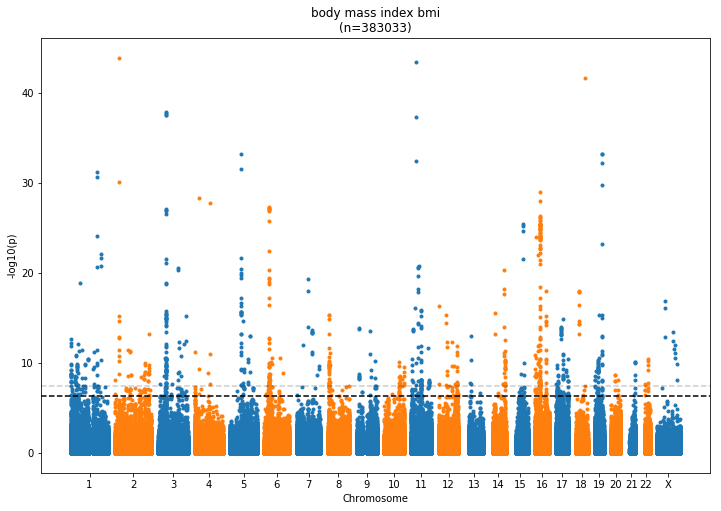

In [20]:
## OLD VERSION

pheno='body_mass_index_bmi'

# if pheno not in df_dict:
df_dict[pheno] = read_saige_gwas(pheno)
plot_manhattan(df=df_dict[pheno])
_ = plt.title(f'{pheno.replace("_"," ")}\n'+f'(n={int(df_dict[pheno].N.mean())})')

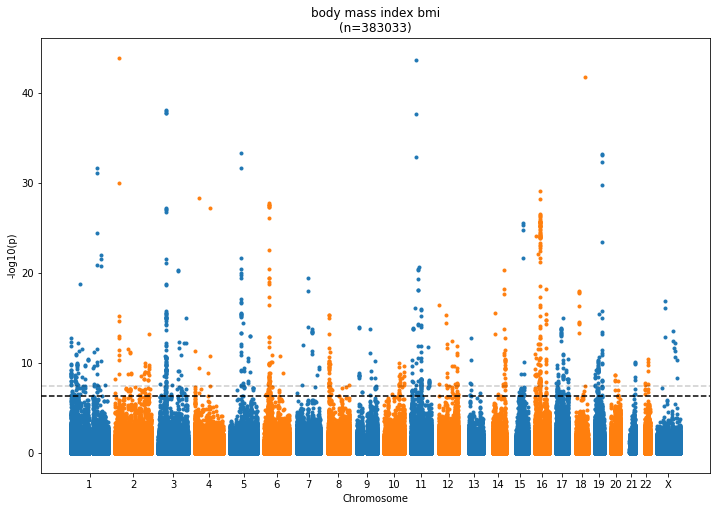

In [16]:
pheno='body_mass_index_bmi'

# if pheno not in df_dict:
df_dict[pheno] = read_saige_gwas(pheno)
plot_manhattan(df=df_dict[pheno])
_ = plt.title(f'{pheno.replace("_"," ")}\n'+f'(n={int(df_dict[pheno].N.mean())})')

No file for body_fat_percentage sex=both_sexes chrX
Removing 543795 lines with "UR"


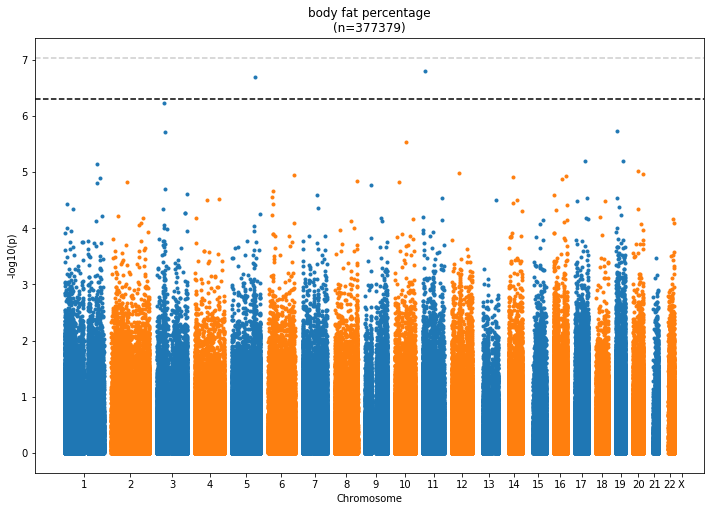

In [45]:
pheno='body_fat_percentage'

# if pheno not in df_dict:
df_dict[pheno] = read_saige_gwas(pheno)
plot_manhattan(df=df_dict[pheno])
_ = plt.title(f'{pheno.replace("_"," ")}\n'+f'(n={int(df_dict[pheno].N.mean())})')

No file for body_mass_index_bmi sex=both_sexes chr1
No file for body_mass_index_bmi sex=both_sexes chrX
Removing 494311 lines with "UR"


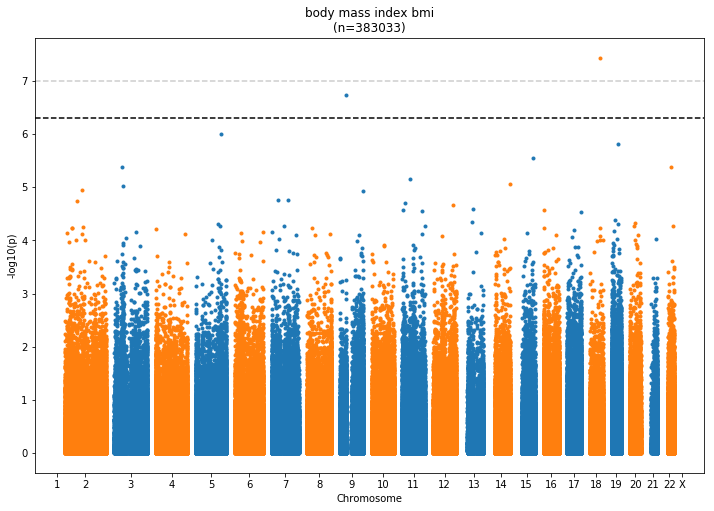

In [46]:
pheno='body_mass_index_bmi'

# if pheno not in df_dict:
df_dict[pheno] = read_saige_gwas(pheno)
plot_manhattan(df=df_dict[pheno])
_ = plt.title(f'{pheno.replace("_"," ")}\n'+f'(n={int(df_dict[pheno].N.mean())})')

Starting body_mass_index_bmi, sex=both_sexes


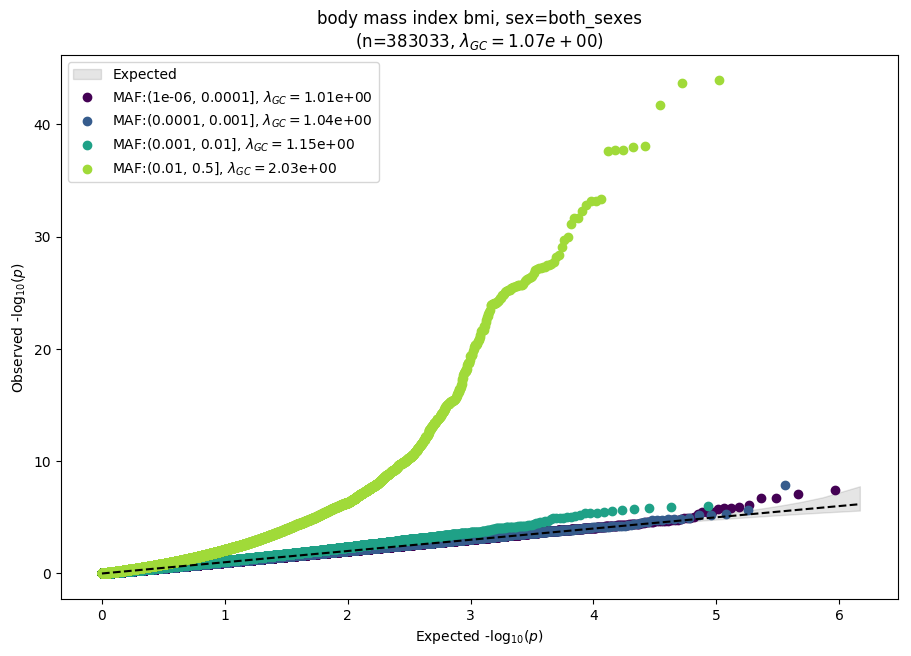

In [18]:
maf_thresholds = [1e-6, 0.0001, 0.001, 0.01, 0.5]
maf_bins = list(zip(maf_thresholds[:-1], maf_thresholds[1:]))

for pheno in OBESITY_PHENOS[:1]:
    for sex in ['both_sexes']: #,'female','male'
        gwas_id=pheno+sex
        try:
            print(f'Starting {pheno}, sex={sex}')
            if gwas_id not in df_dict:
                df_dict[gwas_id] = read_saige_gwas(pheno, sex=sex)
            df, lambda_gc_dict = plot_qq(df=df_dict[gwas_id], maf_bins=maf_bins)
            plt.title(f'{pheno.replace("_"," ")}, sex={sex}\n'+f'(n={int(df.N.mean())}, '+r'$\lambda_{GC}='+f'{lambda_gc_dict["all"]:.2e}$)')

            fname=f'qq_plot.with_maf_bins.{pheno}{f"-{sex}" if sex!="both" else ""}.png'
            plt.savefig(f'/opt/notebooks/{fname}', dpi=300)
            dxpy.upload_local_file(
                filename=f'/opt/notebooks/{fname}',
                name=fname,
                folder='/saige_pipeline/plots/',
                parents=True
            )
        except:
            print(f'Failed {pheno}, sex={sex}')

Variants with defined p-values chr1: 146449
Variants with defined p-values chr2: 100147
Variants with defined p-values chr3: 82437
Variants with defined p-values chr4: 54591
Variants with defined p-values chr5: 61065
Variants with defined p-values chr6: 71328
Variants with defined p-values chr7: 68149
Variants with defined p-values chr8: 54248
Variants with defined p-values chr9: 64589
Variants with defined p-values chr10: 57418
Variants with defined p-values chr11: 94441
Variants with defined p-values chr12: 75332
Variants with defined p-values chr13: 24461
Variants with defined p-values chr14: 45781
Variants with defined p-values chr15: 48504
Variants with defined p-values chr16: 79277
Variants with defined p-values chr17: 92501
Variants with defined p-values chr18: 22414
Variants with defined p-values chr19: 116542
Variants with defined p-values chr20: 41892
Variants with defined p-values chr21: 17650
Variants with defined p-values chr22: 38047
Variants with defined p-values chrX: 3

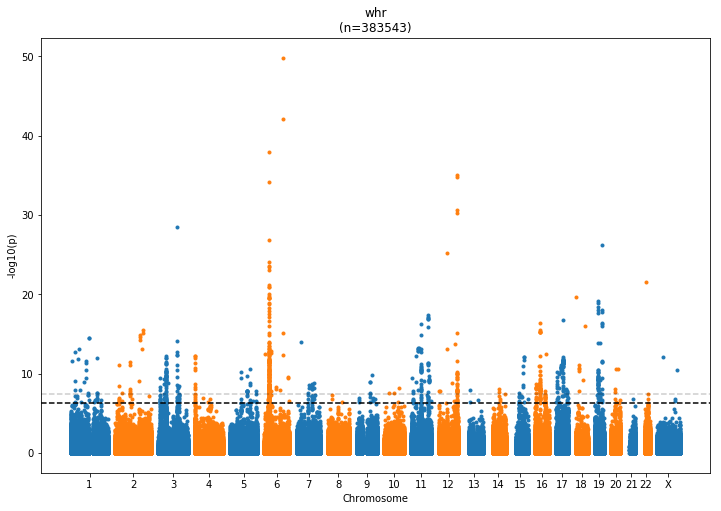

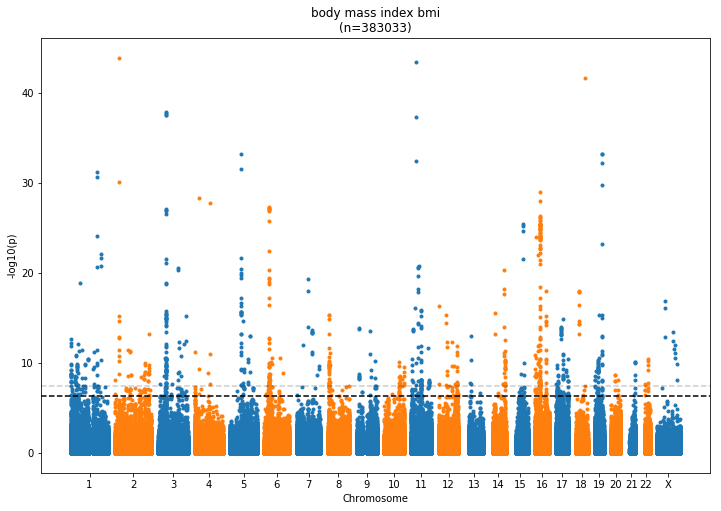

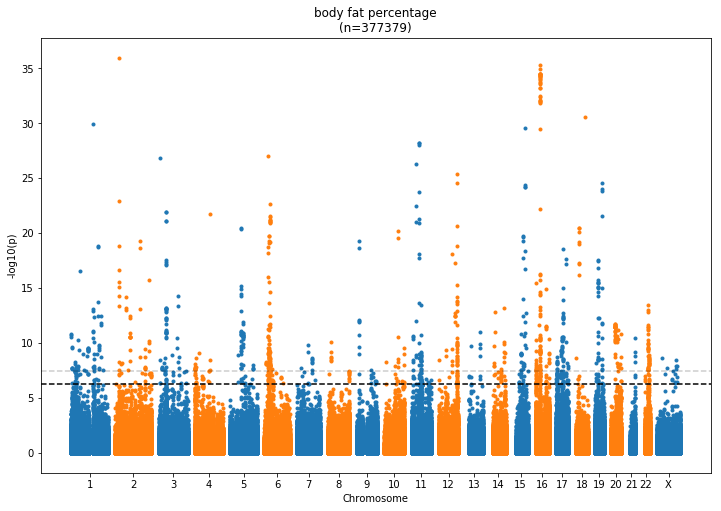

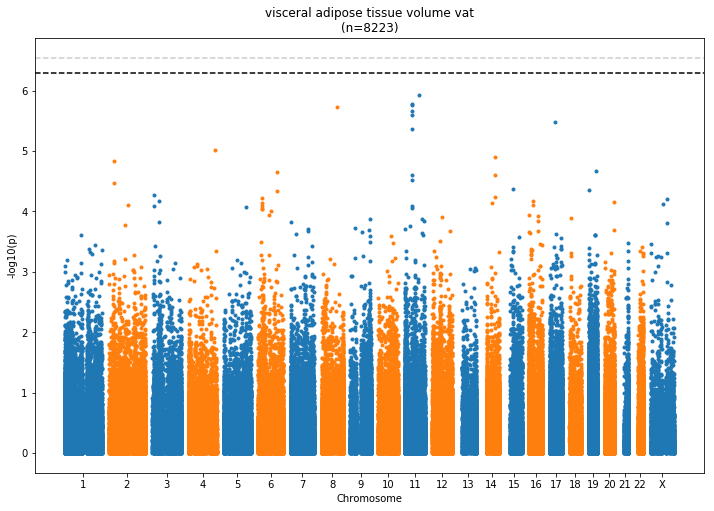

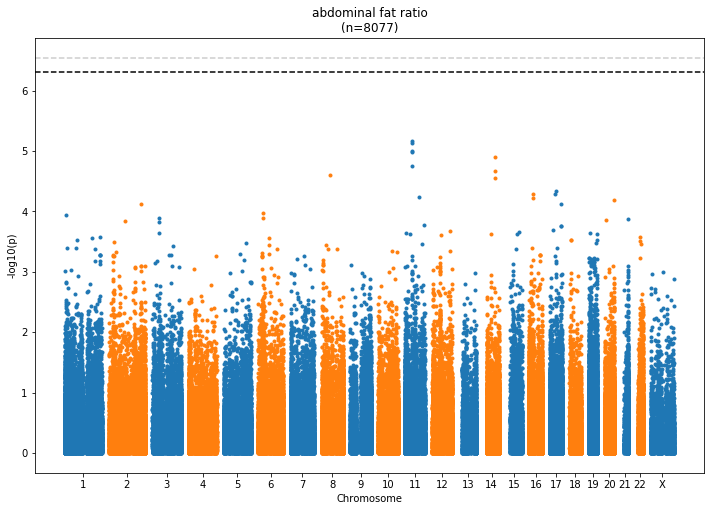

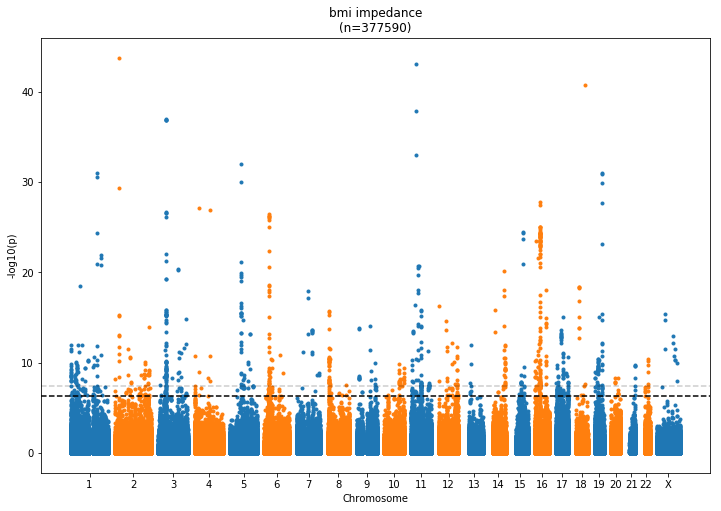

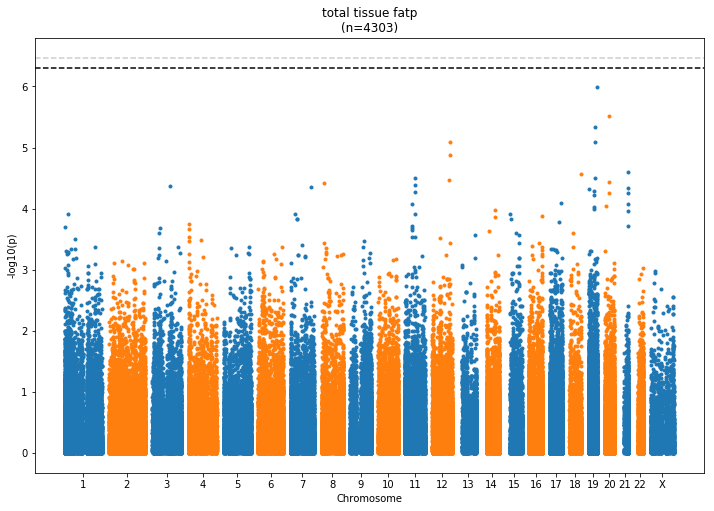

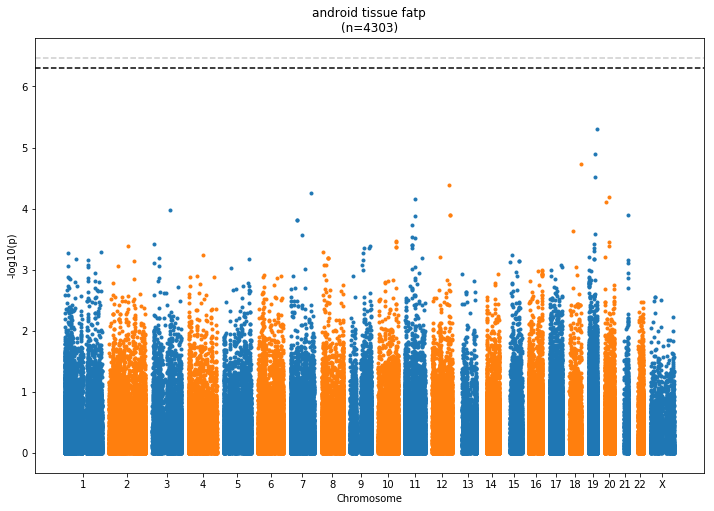

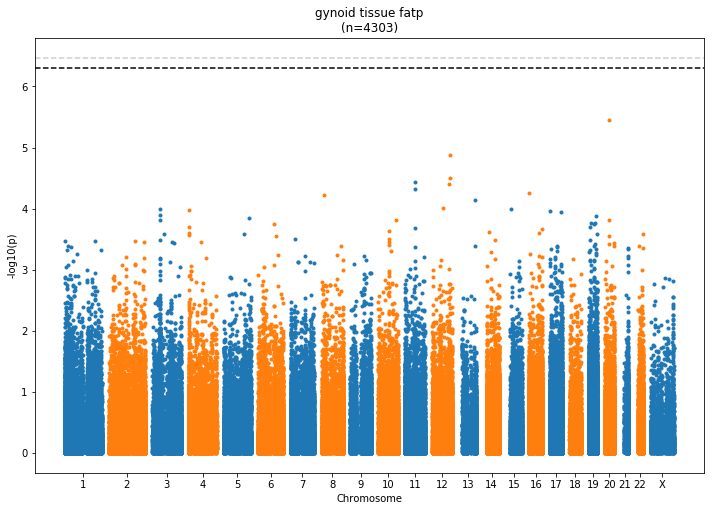

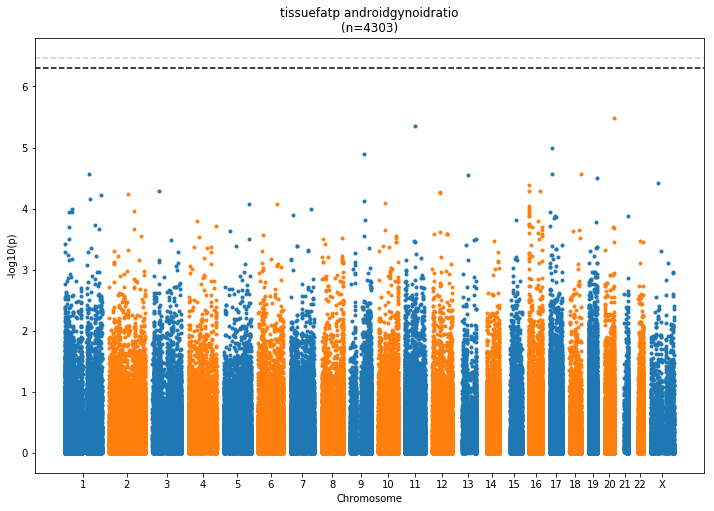

In [37]:
for pheno in OBESITY_PHENOS:
    if pheno not in df_dict:
        df_dict[pheno] = read_saige_gwas(pheno)
    plot_manhattan(df=df_dict[pheno])
    _ = plt.title(f'{pheno.replace("_"," ")}\n'+f'(n={int(df_dict[pheno].N.mean())})')
    
    fname=f'manhattan_plot.{pheno}.png'
    plt.savefig(f'/opt/notebooks/{fname}', dpi=300)
    dxpy.upload_local_file(
        filename=f'/opt/notebooks/{fname}',
        name=fname,
        folder='/saige_pipeline/plots/',
        parents=True
    )

### Sex-stratified Miami plots

In [ ]:
for pheno in OBESITY_PHENOS:
    try:
        for sex in ['male','female']:
            gwas_id = pheno+sex
            if pheno not in df_dict:
                df_dict[gwas_id] = read_saige_gwas(pheno, sex=sex)
        df_f = df_dict[pheno+'female']
        df_m = df_dict[pheno+'male']

        plot_miami(df1=df_f, df2=df_m)
        _ = plt.title(f'{pheno.replace("_"," ")}\n'+f'(TOP: females={int(df1.N.mean())}, BOTTOM: males={int(df2.N.mean())})')

        fname=f'miami_plot.{pheno}-sexstrat.png'
        plt.savefig(f'/opt/notebooks/{fname}', dpi=300)
        dxpy.upload_local_file(
            filename=f'/opt/notebooks/{fname}',
            name=fname,
            folder='/saige_pipeline/plots/',
            parents=True
        )
    except:
        print(f'Failed {pheno}')

## Compare to Genebass

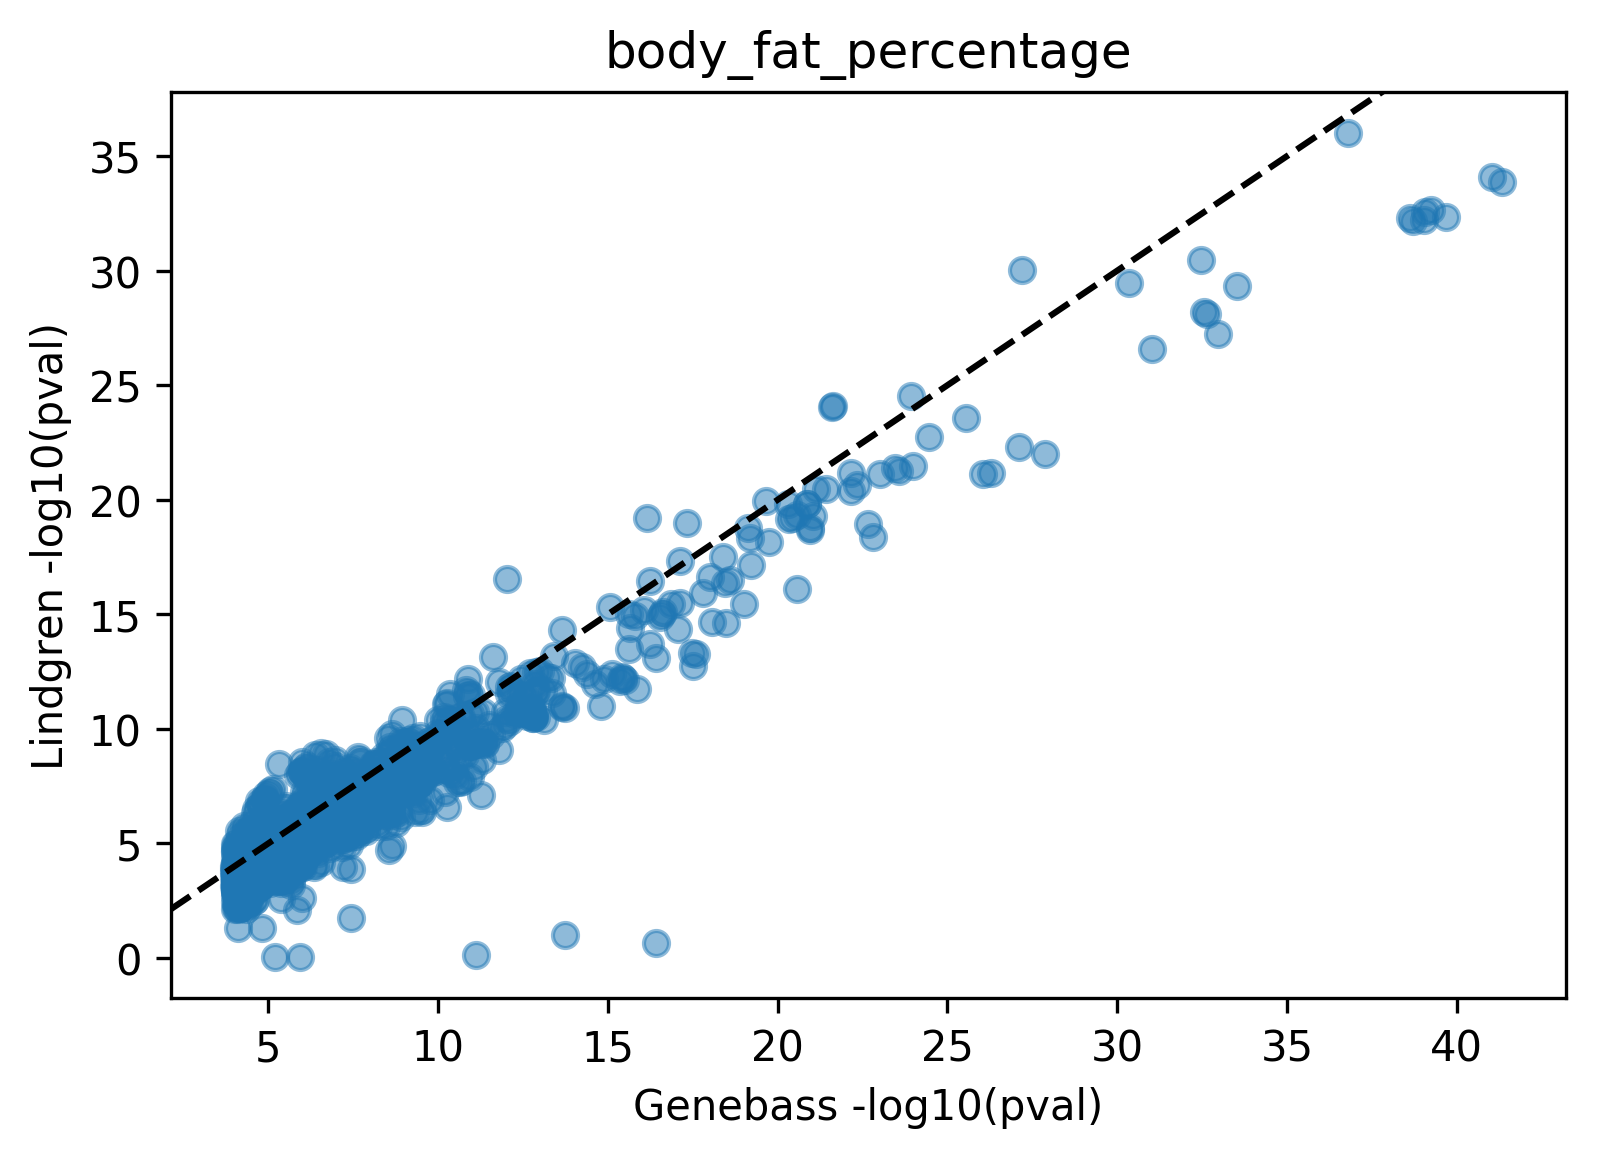

In [15]:
pheno ='body_fat_percentage'
compare_to_genebass(df_dict=df_dict, pheno=pheno)


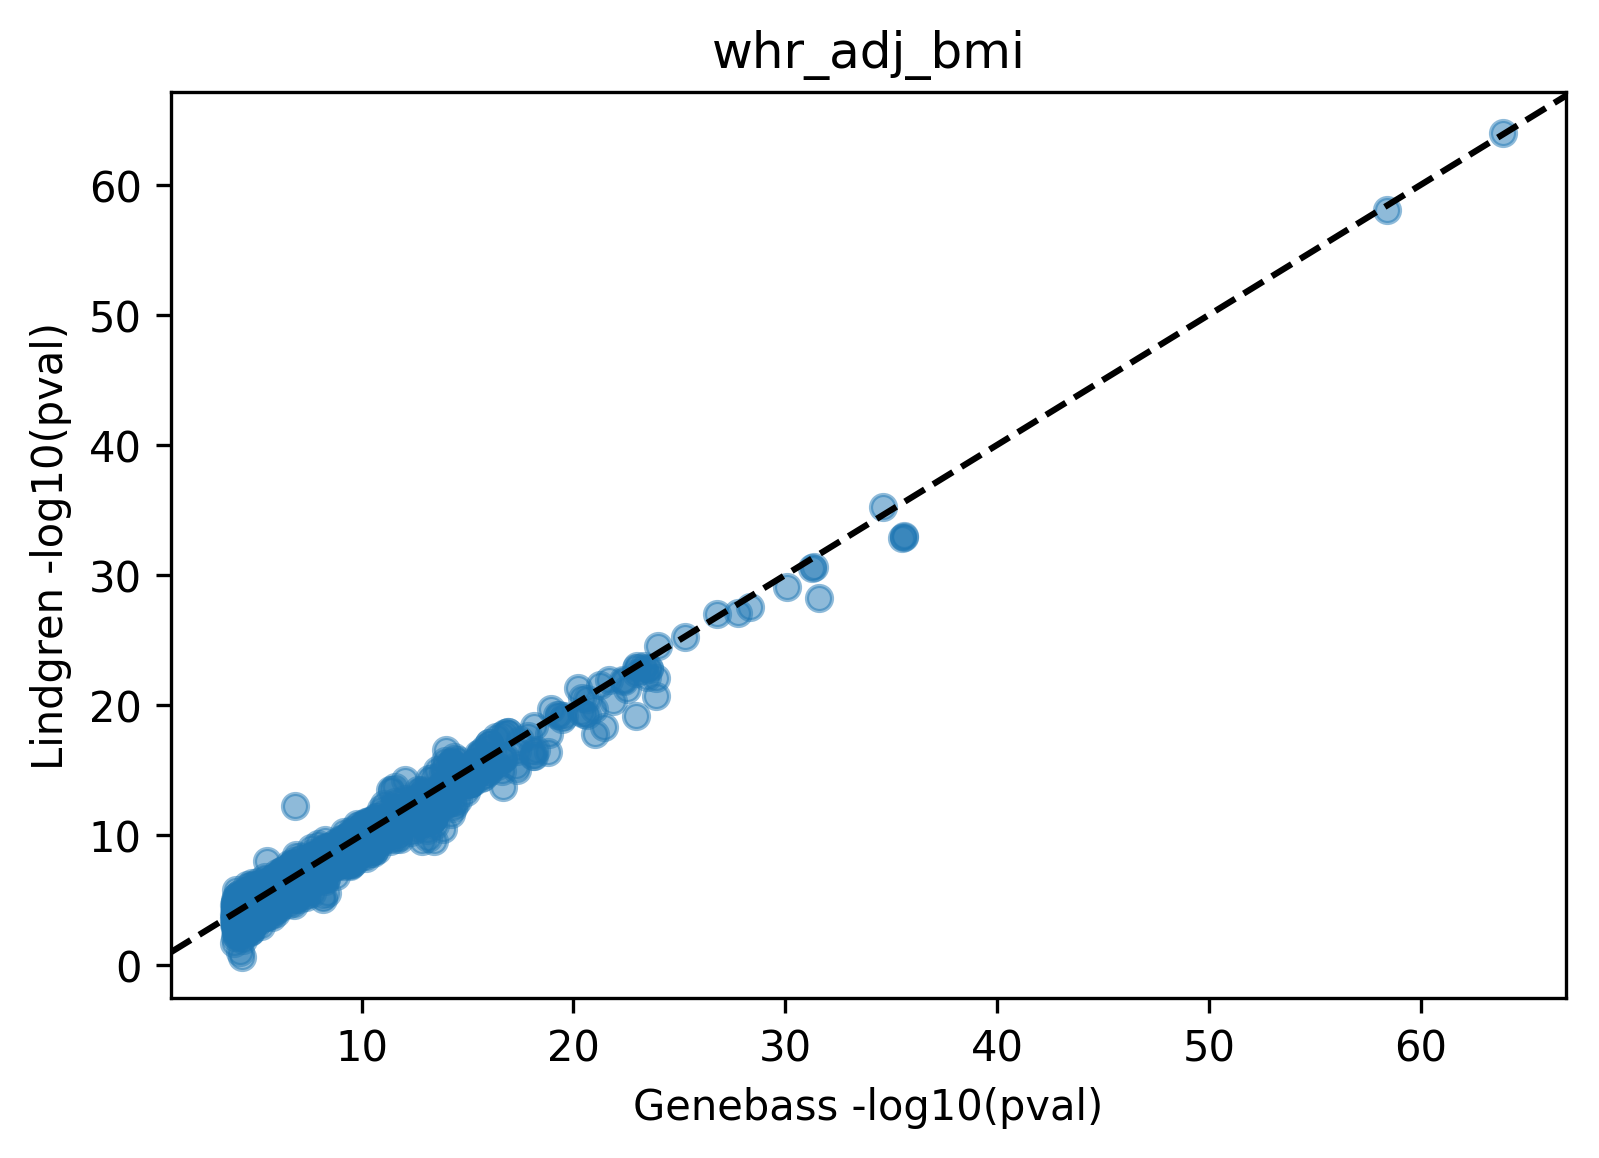

In [16]:
pheno ='whr_adj_bmi'
compare_to_genebass(df_dict=df_dict, pheno=pheno)

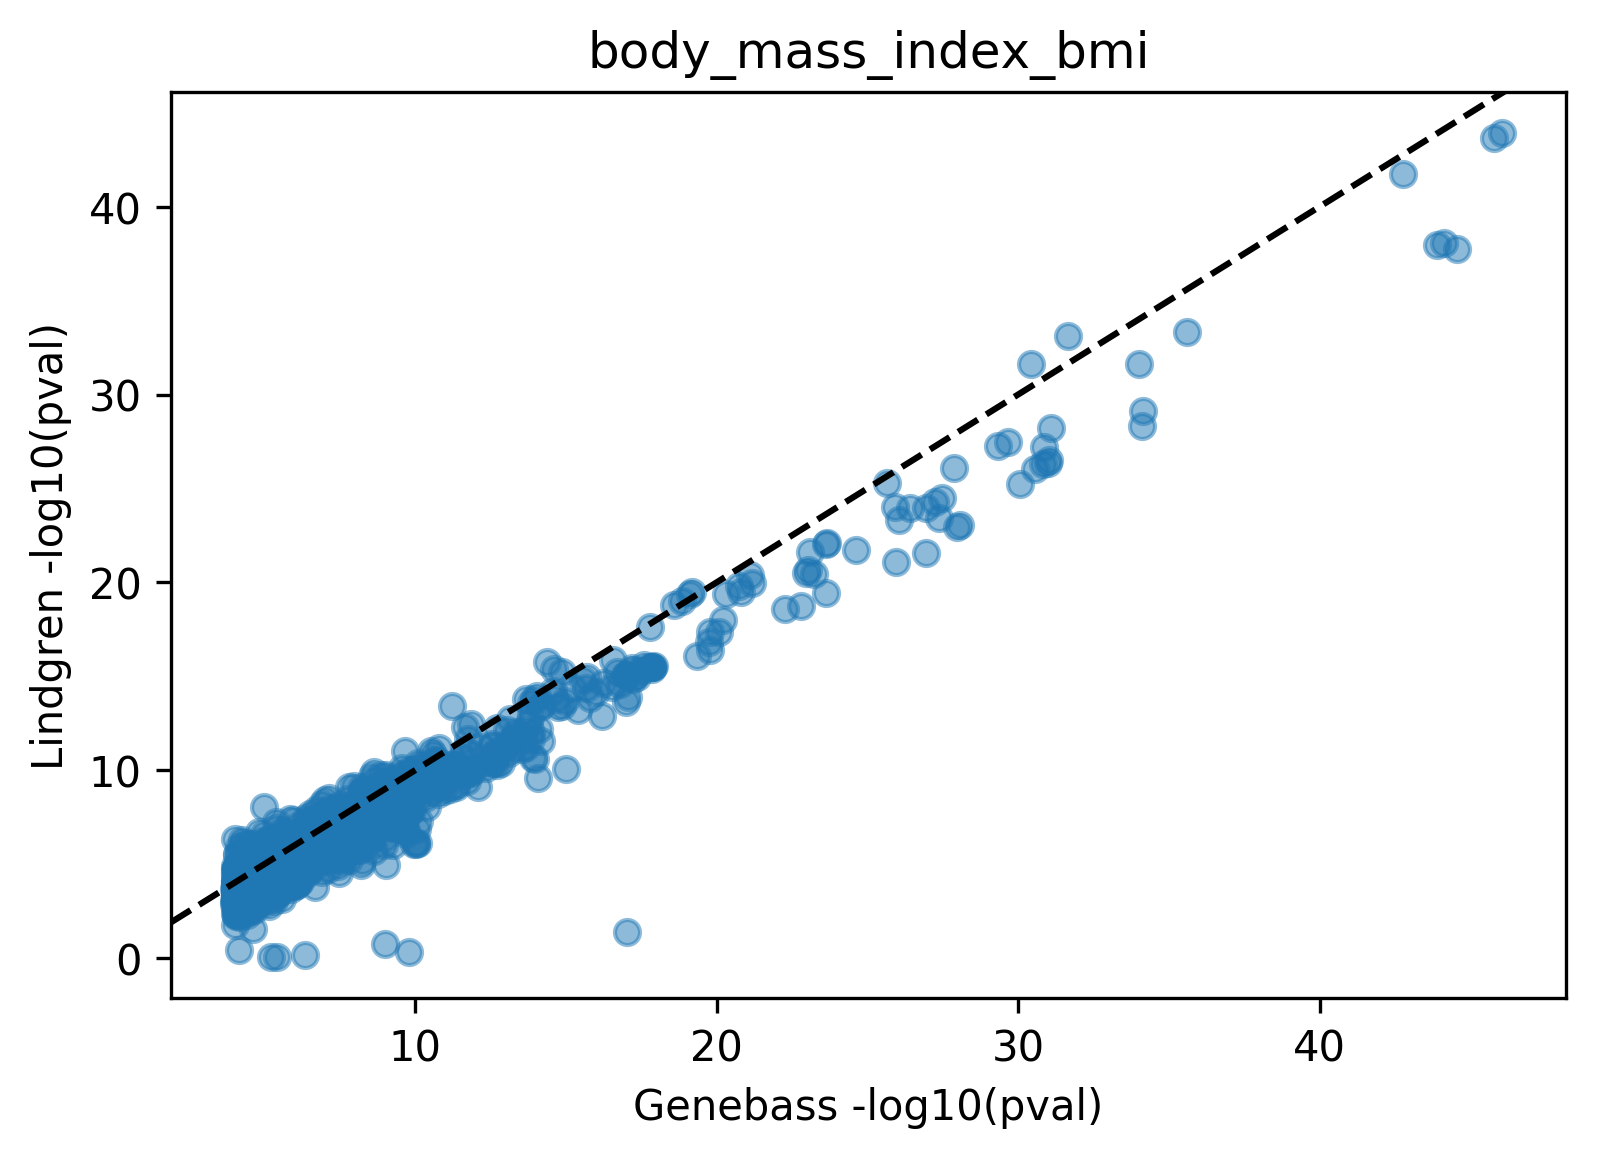

In [17]:
pheno ='body_mass_index_bmi'
compare_to_genebass(df_dict=df_dict, pheno=pheno)

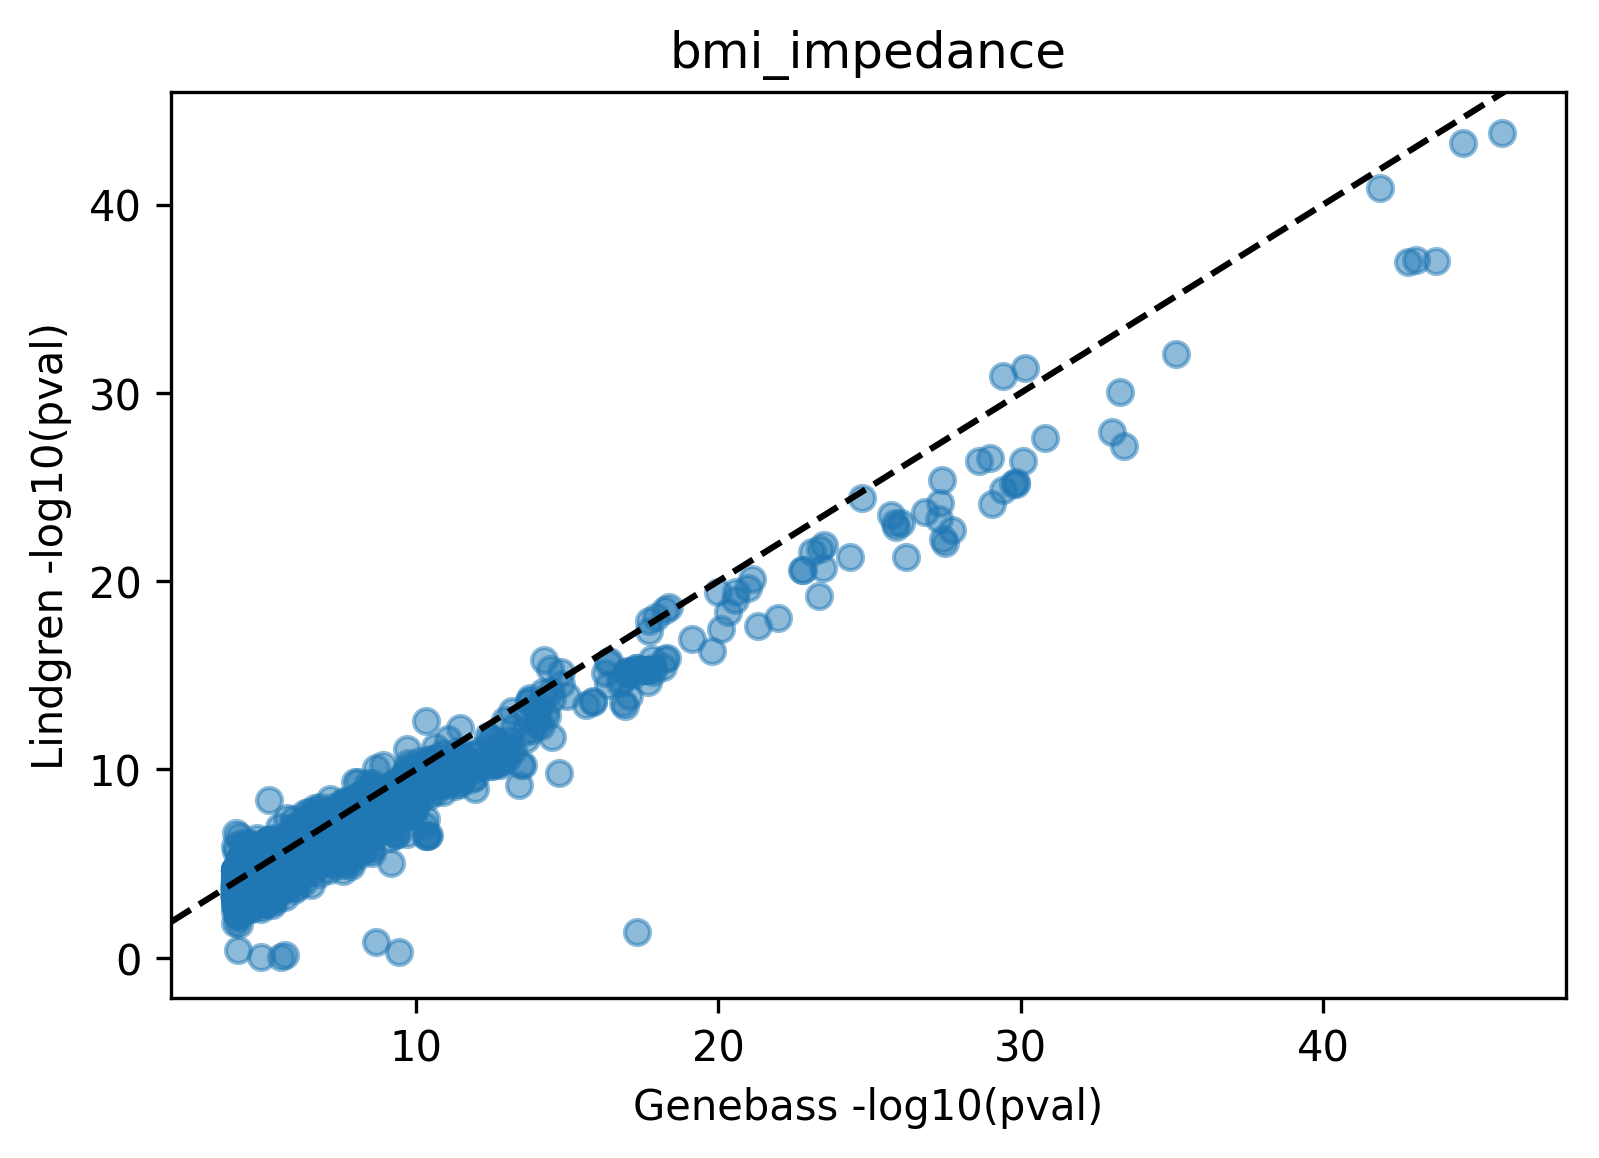

In [18]:
pheno ='bmi_impedance'
compare_to_genebass(df_dict=df_dict, pheno=pheno)

In [19]:
pheno = 'visceral_adipose_tissue_volume_vat'
compare_to_genebass(df_dict=df_dict, pheno=pheno)

KeyError: 'visceral_adipose_tissue_volume_vat'

Text(0.5, 1.0, 'body_fat_percentage')

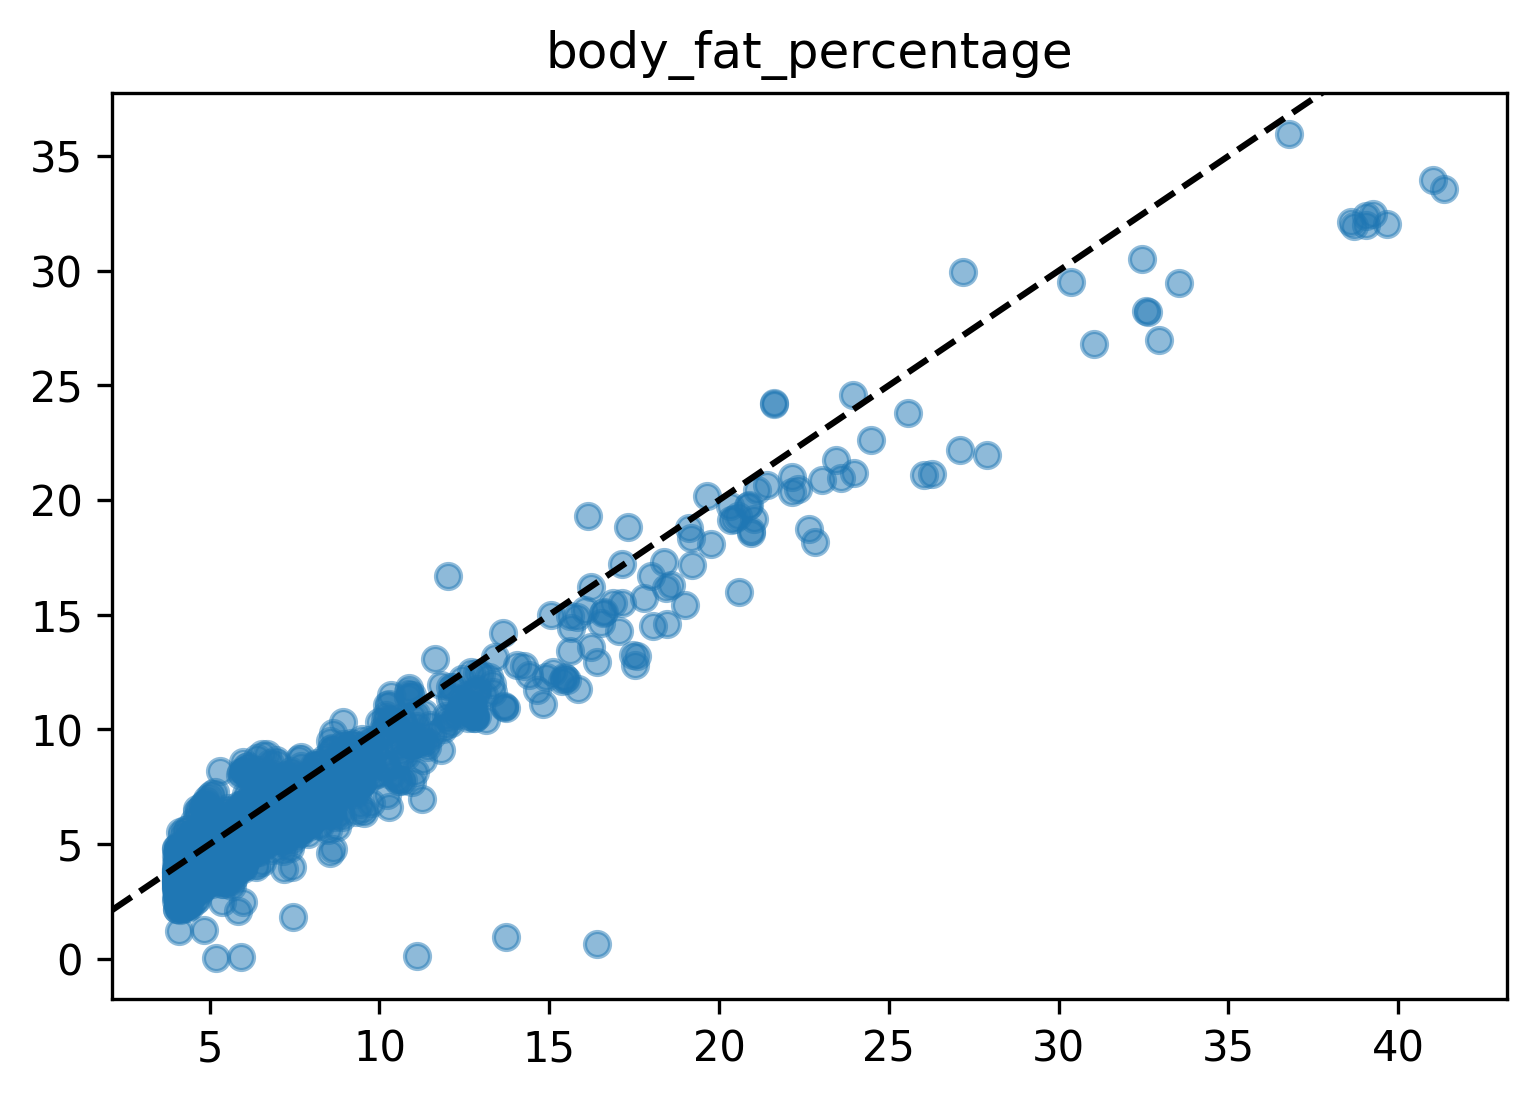

In [39]:
plt.figure(dpi=300)
plt.scatter(
    -np.log10(merged['P-Value']), 
    merged.nlog10pval, alpha=0.5)
ymin, ymax = plt.ylim()
xmin, xmax = plt.xlim()
plt.plot(*[[xmin, xmax]]*2, 'k--')
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.title(pheno)

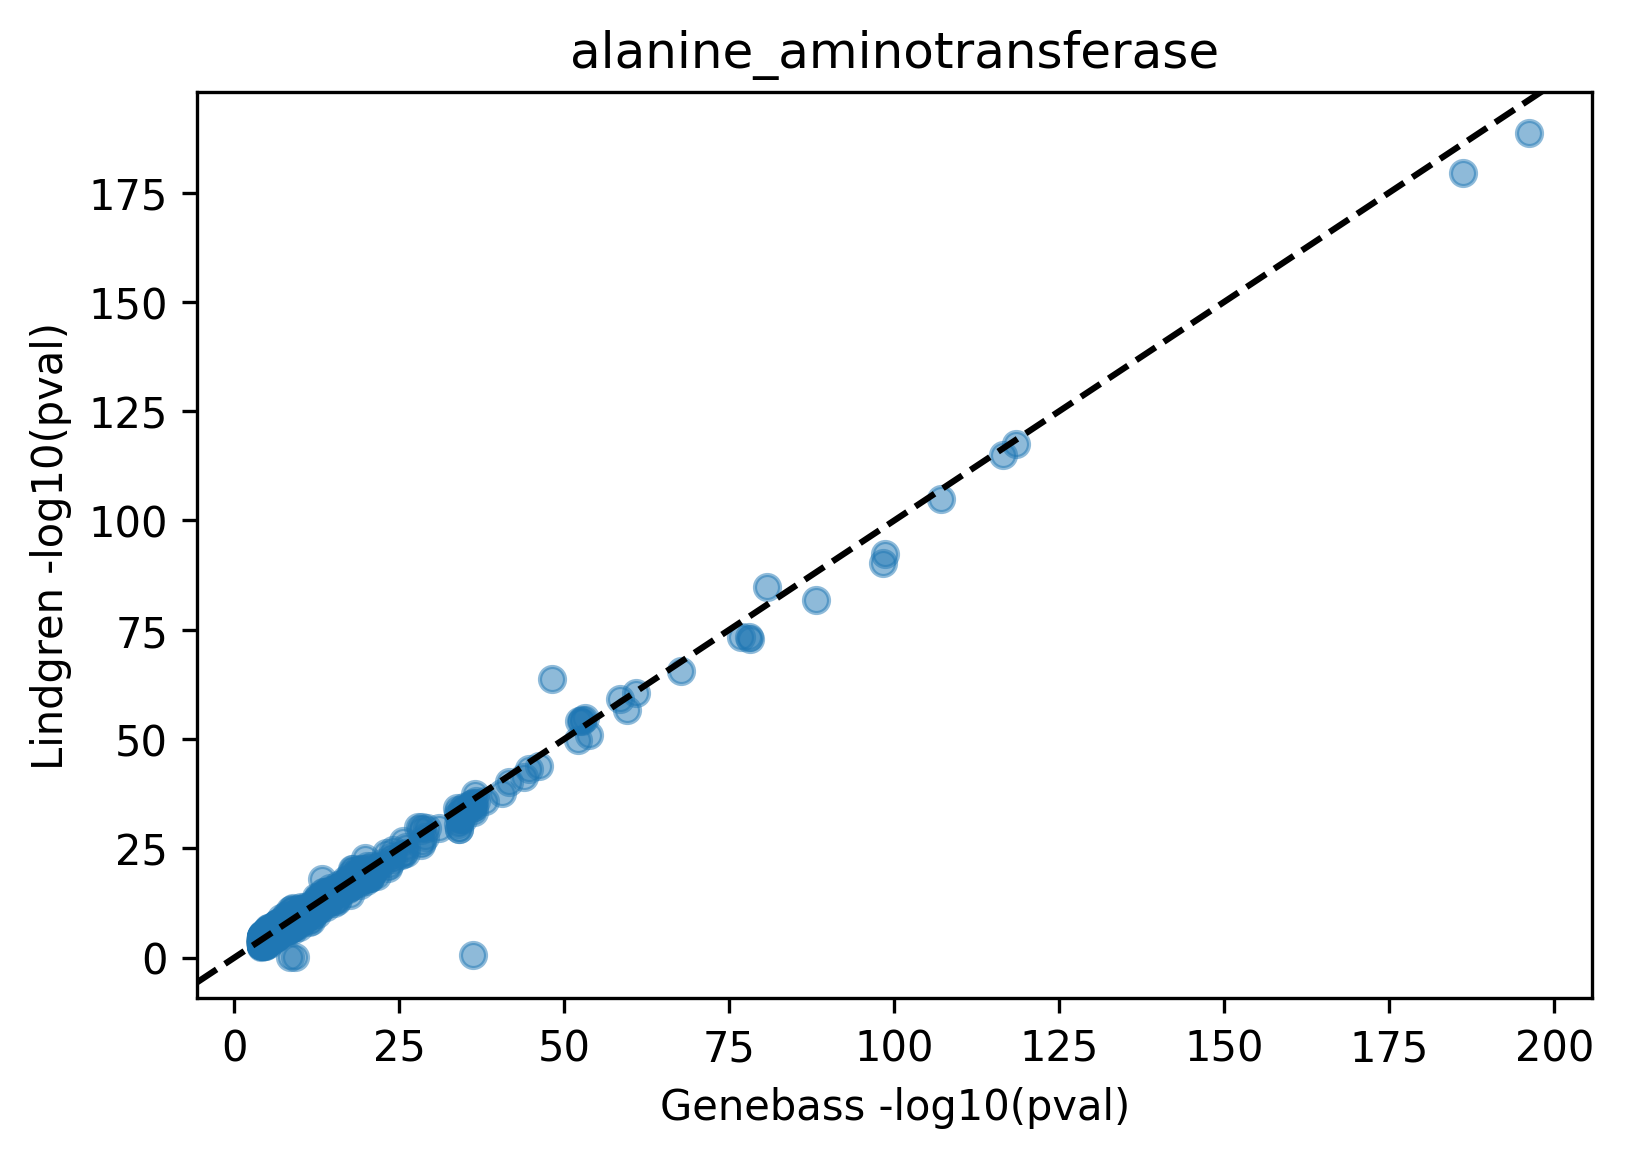

In [10]:
pheno ='alanine_aminotransferase'
merged, df, df_genebass = compare_to_genebass(df_dict=df_dict, pheno=pheno)

In [14]:
df.sort_values(by='nlog10pval', ascending=False)[['varid','p.value','nlog10pval']]

,varid,p.value,nlog10pval
53033,8-144506797-C-G,0.000000e+00,inf
53028,8-144506731-C-G,0.000000e+00,inf
53007,8-144506253-G-T,2.895292e-189,188.538308
38308,10-100152307-C-T,3.059388e-180,179.514365
38336,10-100193948-A-C,1.761165e-147,146.754200
...,...,...,...
42739,12-70587043-C-T,9.999907e-01,0.000004
22462,5-88743564-A-T,9.999925e-01,0.000003
26985,X-141838389-C-CATGTGCCACAT,9.999927e-01,0.000003
56391,12-110915836-A-G,9.999929e-01,0.000003
